In [1]:
# ---------------------------
# 0) Install (Colab) - run once
# ---------------------------
!pip install -q torch torchvision --quiet
!pip install -q opencv-python scikit-learn matplotlib tqdm

In [2]:
# ---------------------------
# 1) Imports & Config
# ---------------------------
import os, glob, json, math, time
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [4]:
import os
os.listdir("/content/drive/MyDrive")

['Surat.docx',
 'Surat.docx.gdoc',
 'Ahli Jawatankuasa Persatuan Matematik.gdoc',
 'IMG-20180113-WA0012.jpg',
 'Pj isu dlm sukan  Projek 2.gdoc',
 '2013 F4 phy mid year - answer(1).pdf',
 '中一壬K1I.pptx',
 '中一壬K1I (1).gslides',
 '中一壬K1I.gslides',
 '中二庚 K2G 校刊.docx',
 '中二庚 K2G 校刊.gdoc',
 'class photo.docx',
 'class photo.gdoc',
 'markah insentif_VinnieTiangWenYing_S4A',
 'classk2f.pages',
 '校刊名单8.gdoc',
 '校刊名单 (1).docx',
 '校刊名单.docx',
 '校刊名单3.docx',
 '校刊名单4.gdoc',
 '3 Koay Peik Yong (1).jpg',
 '2 Chew Yuen Choon.jpg',
 '1 Tay Yoke Chew.jpg',
 '4 Ooi Swee Eng .jpg',
 '5 Chu Kim Yeap.jpg',
 '6 Heah Gaik See.jpg',
 '7 Chew Ho Im.jpg',
 '8 Chong Lee Sean.jpg',
 '9 Cheng Ley Sim.jpg',
 '10 Cheok Gaik Mei.jpg',
 '11 Gan Chee Meng.jpg',
 '12 Jaswant Kaur.jpg',
 '13 Mashitah.jpg',
 '15 Phung Kit Mei.jpg',
 '16 Low Bee Leng.jpg',
 '14 Rathimalar.JPG',
 '17 Ong Phaik See.jpg',
 '18 Ooi Chit Ping.jpg',
 '19 Sarasawathy AP Mahalinggam.jpg',
 '20 Angeline Chee May Lin.jpg',
 '22 Ong Lay Peng.jpg',
 '2

In [10]:
# 📌 Step C: Find All Paired Files

import glob
import os
from sklearn.model_selection import train_test_split

data_dir = "/content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4"

depth_files = sorted(glob.glob(os.path.join(data_dir, "*dented_depth.npy")))
mask_files = sorted(glob.glob(os.path.join(data_dir, "*dent_mask.png")))

items = list(zip(depth_files, mask_files))
print("Total paired samples:", len(items))

# ---------------------------
# 2) Paths (EDIT if needed)
# ---------------------------
DATA_DIR = data_dir  # <-- set to your folder
OUT_DIR = os.path.join(data_dir, "predictions")
os.makedirs(OUT_DIR, exist_ok=True)


Total paired samples: 1200


In [11]:
# ---------------------------
# 3) Dataset (CORRECTED VERSION)
# ---------------------------
class DepthDentDataset(Dataset):
    """
    Input: depth .npy (H,W)
           mask .png (H,W) or .npy (H,W) (binary 0/255 or 0/1)
    Output: tensor input (C,H,W) where C=3 -> [depth_norm, gx_norm, gy_norm]
            mask tensor (1,H,W) float32 0/1
    """
    def __init__(self, samples: List[Tuple[str,str]], augment: bool=False):
        self.samples = samples
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def _load_depth(self, path):
        d = np.load(path).astype(np.float32)
        return d

    def _load_mask(self, path):
        p = Path(path)
        if p.suffix.lower() == ".npy":
            m = np.load(path)
            m = (m > 0).astype(np.uint8)
        else:
            m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if m is None:
                # Handle missing mask gracefully or raise error
                # return np.zeros((256, 256), dtype=np.uint8)
                raise RuntimeError(f"Cannot read mask: {path}")
            m = (m > 127).astype(np.uint8)
        return m

    def _safe_normalize_and_fill(self, depth):
        """
        CRITICAL FIX:
        1. Fills background with Median depth (removes the 'Cliff Edge' for gradients).
        2. Normalizes Wall to [0.1, 1.0] (makes Wall distinct from 0.0 background).
        """
        valid = np.isfinite(depth) & (depth > 0)

        # Handle empty files
        if not np.any(valid):
            return np.zeros_like(depth), np.zeros_like(depth)

        d_valid = depth[valid]
        d_min = np.min(d_valid)
        d_max = np.max(d_valid)
        d_med = np.median(d_valid) # The 'average' wall depth

        # 1. Create a "filled" map for Gradient calculation
        # We fill background with Median so Sobel sees a flat plane, not a cliff.
        depth_filled = depth.copy()
        depth_filled[~valid] = d_med

        # 2. Create the Normalized map for Input
        # Map valid range to [0.1, 1.0]
        range_val = d_max - d_min
        if range_val < 1e-6:
            range_val = 1.0

        depth_norm = np.zeros_like(depth)
        # Formula: 0.1 + 0.9 * (val - min) / (max - min)
        depth_norm[valid] = 0.1 + 0.9 * ((depth[valid] - d_min) / range_val)

        return depth_norm, depth_filled

    def _gradients(self, depth_filled):
        # Run Sobel on the FILLED depth (No cliff edges!)
        gx = cv2.Sobel(depth_filled, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(depth_filled, cv2.CV_32F, 0, 1, ksize=3)

        # Robust normalization (same as before, but on clean data)
        def robust_norm(x):
            v = x.flatten()
            v = v[np.isfinite(v)]
            if v.size == 0:
                return np.zeros_like(x, dtype=np.float32)
            med = np.median(v)
            mad = np.median(np.abs(v - med)) + 1e-6
            out = (x - med) / (3.0 * mad)
            out = np.clip(out, -3.0, 3.0)
            out = (out - out.min()) / (out.max() - out.min() + 1e-9)
            return out.astype(np.float32)

        return robust_norm(gx), robust_norm(gy)

    def __getitem__(self, idx):
        depth_path, mask_path = self.samples[idx]
        depth = self._load_depth(depth_path)          # shape (H,W) float32
        mask = self._load_mask(mask_path)             # uint8 0/1

        # 1. Clean Depth & Fill Background
        depth_n, depth_filled = self._safe_normalize_and_fill(depth)

        # 2. Compute Gradients on the FILLED depth
        gx, gy = self._gradients(depth_filled)

        # 3. MASK the Gradients
        # We computed gradients on filled data, but we force background to 0.0
        # for the final network input.
        valid_mask = (depth_n > 0).astype(np.float32)
        gx = gx * valid_mask
        gy = gy * valid_mask

        # stack -> (C,H,W)
        inp = np.stack([depth_n, gx, gy], axis=0).astype(np.float32)

        # augment simple flips
        if self.augment:
            if np.random.rand() < 0.5:
                inp = inp[:, :, ::-1]   # hflip
                mask = mask[:, ::-1]
            if np.random.rand() < 0.5:
                inp = inp[:, ::-1, :]   # vflip
                mask = mask[::-1, :]

        mask = (mask > 0).astype(np.float32)[None, ...]   # (1,H,W)
        return torch.from_numpy(inp.copy()), torch.from_numpy(mask.copy())

In [12]:
# ---------------------------
# 4) Model: Attention-UNet
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.ReLU(inplace=True),
                                 nn.Conv2d(F_int, 1, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Upsample gating signal to match x1 size if needed
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)

        psi = self.psi(g1 + x1)
        return x * psi

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, filters=[32,64,128,256]):
        super().__init__()
        f1, f2, f3, f4 = filters
        self.enc1 = ConvBlock(in_channels, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)
        self.center = ConvBlock(f4, f4*2)

        self.att4 = AttentionGate(F_g=f4*2, F_l=f4, F_int=f4)
        self.dec4 = UpBlock(f4*2, f4)
        self.att3 = AttentionGate(F_g=f4, F_l=f3, F_int=f3)
        self.dec3 = UpBlock(f4, f3)
        self.att2 = AttentionGate(F_g=f3, F_l=f2, F_int=f2)
        self.dec2 = UpBlock(f3, f2)
        self.att1 = AttentionGate(F_g=f2, F_l=f1, F_int=f1)
        self.dec1 = UpBlock(f2, f1)

        self.final = nn.Conv2d(f1, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        c = self.center(self.pool4(e4))

        g4 = c
        x4 = self.att4(g4, e4)
        d4 = self.dec4(c, x4)

        g3 = d4
        x3 = self.att3(g3, e3)
        d3 = self.dec3(d4, x3)

        g2 = d3
        x2 = self.att2(g2, e2)
        d2 = self.dec2(d3, x2)

        g1 = d2
        x1 = self.att1(g1, e1)
        d1 = self.dec1(d2, x1)

        out = self.final(d1)
        return out

In [13]:
# ---------------------------
# 5) Losses & Metrics
# ---------------------------
def dice_loss_tensor(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1,2,3))
    denom = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = 1 - ((2*inter + smooth) / (denom + smooth))
    return dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, pred, target):
        # pred: logits
        bce_loss = self.bce(pred, target)
        pt = torch.exp(-bce_loss)
        loss = ((1-pt)**self.gamma * bce_loss).mean()
        return loss

def combined_loss(pred, target):
    # 0.5 * Dice + 0.5 * Focal
    return 0.5 * dice_loss_tensor(pred, target) + 0.5 * FocalLoss()(pred, target)

# Metrics
def iou_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = (pred_bin + target - pred_bin*target).sum(dim=(1,2,3))
    return ((inter + eps) / (union + eps)).mean().item()

def dice_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    denom = (pred_bin + target).sum(dim=(1,2,3))
    return ((2*inter + eps) / (denom + eps)).mean().item()

def precision_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fp = (pred_bin * (1-target)).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fp + eps)).mean().item()

def recall_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fn = ((1-pred_bin) * target).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fn + eps)).mean().item()

In [14]:
# ---------------------------
# 6) Prepare dataset & sampler
# ---------------------------
# Pair depth and mask files
depth_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*dented_depth.npy")))
pairs = []
for dp in depth_paths:
    base = os.path.basename(dp).replace("_dented_depth.npy","")
    mp = os.path.join(DATA_DIR, base + "_dent_mask.png")
    if not os.path.exists(mp):
        mp_alt = os.path.join(DATA_DIR, base + "_dent_mask.npy")
        if os.path.exists(mp_alt):
            mp = mp_alt
        else:
            print("Missing mask for:", dp)
            continue
    pairs.append((dp, mp))

print("Total paired samples:", len(pairs))

# Proper train/val/test split: 70% train, 15% val, 15% test
# First split: separate out test set (15%)
train_val_pairs, test_pairs = train_test_split(pairs, test_size=0.15, random_state=42)
# Second split: split remaining into train (70% of total) and val (15% of total)
# Since we have 85% left, we need 70/85 = 0.8235 to get 70% of original
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1765, random_state=42)

print(f"Train samples: {len(train_pairs)} ({100*len(train_pairs)/len(pairs):.1f}%)")
print(f"Val samples: {len(val_pairs)} ({100*len(val_pairs)/len(pairs):.1f}%)")
print(f"Test samples: {len(test_pairs)} ({100*len(test_pairs)/len(pairs):.1f}%)")
print("⚠️ Test set is completely separate and will ONLY be used for final evaluation!")

# compute weights for sampler (oversample positive mask images)
def sample_weight(pair):
    _, mask_path = pair
    if mask_path.endswith(".npy"):
        m = np.load(mask_path)
    else:
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    has_pos = (m > 0).sum() > 0
    return 1.0 if has_pos else 0.2  # give less weight to no-dent images

weights = [sample_weight(p) for p in train_pairs]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_ds = DepthDentDataset(train_pairs, augment=True)
val_ds = DepthDentDataset(val_pairs, augment=False)

train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

Total paired samples: 1200
Train samples: 839 (69.9%)
Val samples: 181 (15.1%)
Test samples: 180 (15.0%)
⚠️ Test set is completely separate and will ONLY be used for final evaluation!


In [15]:
# ---------------------------
# 7) Create model / optimizer
# ---------------------------
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

if scheduler.num_bad_epochs == 0:
    print("↘ LR reduced!")



↘ LR reduced!


In [16]:
# ---------------------------
# 8) Training loop with Early Stopping
# ---------------------------
NUM_EPOCHS = 50  # 50 epochs, but early stopping will prevent overfitting
best_iou = 0.0
save_path = os.path.join(OUT_DIR, "best_attention_unet.pth")

# Early stopping parameters
patience = 7  # Stop if no improvement for 7 epochs
patience_counter = 0
min_delta = 0.001  # Minimum change to qualify as improvement

# Track history for analysis
train_losses = []
val_losses = []
val_ious = []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for inp, mask in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        inp = inp.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(inp)
        loss = combined_loss(outputs, mask)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    iou_acc = 0.0
    dice_acc = 0.0
    prec_acc = 0.0
    rec_acc = 0.0
    n_batches = 0
    with torch.no_grad():
        for inp, mask in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            loss = combined_loss(outputs, mask)
            val_loss += float(loss.item())
            iou_acc += iou_score_batch(outputs, mask)
            dice_acc += dice_score_batch(outputs, mask)
            prec_acc += precision_batch(outputs, mask)
            rec_acc += recall_batch(outputs, mask)
            n_batches += 1

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / (n_batches if n_batches>0 else 1)
    avg_iou = iou_acc / (n_batches if n_batches>0 else 1)
    avg_dice = dice_acc / (n_batches if n_batches>0 else 1)
    avg_prec = prec_acc / (n_batches if n_batches>0 else 1)
    avg_rec = rec_acc / (n_batches if n_batches>0 else 1)

    # Track history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_iou)

    # Calculate gap between train and val loss (overfitting indicator)
    loss_gap = avg_train_loss - avg_val_loss

    print(f"Epoch {epoch}/{NUM_EPOCHS} TrainLoss: {avg_train_loss:.4f} ValLoss: {avg_val_loss:.4f} Val IoU: {avg_iou:.4f} Dice: {avg_dice:.4f} Prec: {avg_prec:.4f} Rec: {avg_rec:.4f} Gap: {loss_gap:.4f}")

    # scheduler step on IoU
    scheduler.step(avg_iou)

    # Early stopping check: improve on IoU
    if avg_iou > best_iou + min_delta:
        best_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"✓ Saved best model (IoU: {best_iou:.4f}): {save_path}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience} patience)")

        # Check for overfitting warning
        if loss_gap < -0.05:  # Train loss significantly lower than val loss
            print(f"  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)")

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏹️  Early stopping triggered! No improvement for {patience} epochs.")
        print(f"Best IoU achieved: {best_iou:.4f} at epoch {epoch - patience}")
        break

print(f"\nTraining complete. Best IoU: {best_iou:.4f}")1print(f"Final train/val loss gap: {train_losses[-1] - val_losses[-1]:.4f}")

Epoch 1 [val]: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s]


Epoch 1/50 TrainLoss: 0.4849 ValLoss: 0.4709 Val IoU: 0.2542 Dice: 0.3173 Prec: 0.2644 Rec: 0.9551 Gap: 0.0140
✓ Saved best model (IoU: 0.2542): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 2 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.92it/s]


Epoch 2/50 TrainLoss: 0.4130 ValLoss: 0.4498 Val IoU: 0.3499 Dice: 0.4113 Prec: 0.3759 Rec: 0.8905 Gap: -0.0368
✓ Saved best model (IoU: 0.3499): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 3 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.57it/s]


Epoch 3/50 TrainLoss: 0.3597 ValLoss: 0.4172 Val IoU: 0.4362 Dice: 0.4984 Prec: 0.4932 Rec: 0.8444 Gap: -0.0575
✓ Saved best model (IoU: 0.4362): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 4 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.70it/s]


Epoch 4/50 TrainLoss: 0.3457 ValLoss: 0.4129 Val IoU: 0.4634 Dice: 0.5289 Prec: 0.5630 Rec: 0.8134 Gap: -0.0673
✓ Saved best model (IoU: 0.4634): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 5 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.28it/s]


Epoch 5/50 TrainLoss: 0.3354 ValLoss: 0.4091 Val IoU: 0.4351 Dice: 0.5020 Prec: 0.5169 Rec: 0.8337 Gap: -0.0737
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 6 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.83it/s]


Epoch 6/50 TrainLoss: 0.3300 ValLoss: 0.4069 Val IoU: 0.4653 Dice: 0.5297 Prec: 0.5041 Rec: 0.9027 Gap: -0.0770
✓ Saved best model (IoU: 0.4653): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 7 [val]: 100%|██████████| 46/46 [00:08<00:00,  5.70it/s]


Epoch 7/50 TrainLoss: 0.3248 ValLoss: 0.4046 Val IoU: 0.4826 Dice: 0.5477 Prec: 0.5093 Rec: 0.9168 Gap: -0.0798
✓ Saved best model (IoU: 0.4826): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 8 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.64it/s]


Epoch 8/50 TrainLoss: 0.3267 ValLoss: 0.4002 Val IoU: 0.5219 Dice: 0.5871 Prec: 0.5932 Rec: 0.8547 Gap: -0.0735
✓ Saved best model (IoU: 0.5219): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 9 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s]


Epoch 9/50 TrainLoss: 0.3218 ValLoss: 0.4034 Val IoU: 0.5616 Dice: 0.6258 Prec: 0.6415 Rec: 0.8415 Gap: -0.0816
✓ Saved best model (IoU: 0.5616): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 10 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.94it/s]


Epoch 10/50 TrainLoss: 0.3179 ValLoss: 0.4026 Val IoU: 0.4105 Dice: 0.4749 Prec: 0.4390 Rec: 0.9090 Gap: -0.0847
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 11 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.82it/s]


Epoch 11/50 TrainLoss: 0.3086 ValLoss: 0.3977 Val IoU: 0.4797 Dice: 0.5474 Prec: 0.5386 Rec: 0.8591 Gap: -0.0890
  No improvement (2/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 12 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.65it/s]


Epoch 12/50 TrainLoss: 0.3056 ValLoss: 0.3952 Val IoU: 0.5158 Dice: 0.5828 Prec: 0.6057 Rec: 0.8204 Gap: -0.0896
  No improvement (3/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 13 [val]: 100%|██████████| 46/46 [00:08<00:00,  5.68it/s]


Epoch 13/50 TrainLoss: 0.3047 ValLoss: 0.4011 Val IoU: 0.4176 Dice: 0.4820 Prec: 0.4851 Rec: 0.8477 Gap: -0.0964
  No improvement (4/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 14 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.06it/s]


Epoch 14/50 TrainLoss: 0.2873 ValLoss: 0.3884 Val IoU: 0.5465 Dice: 0.6123 Prec: 0.6060 Rec: 0.8807 Gap: -0.1011
  No improvement (5/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 15 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.67it/s]


Epoch 15/50 TrainLoss: 0.2805 ValLoss: 0.3898 Val IoU: 0.5896 Dice: 0.6561 Prec: 0.6761 Rec: 0.8405 Gap: -0.1093
✓ Saved best model (IoU: 0.5896): /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/best_attention_unet.pth


Epoch 16 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.86it/s]


Epoch 16/50 TrainLoss: 0.2913 ValLoss: 0.3903 Val IoU: 0.5361 Dice: 0.6033 Prec: 0.5853 Rec: 0.9041 Gap: -0.0990
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 17 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.88it/s]


Epoch 17/50 TrainLoss: 0.2853 ValLoss: 0.3896 Val IoU: 0.5180 Dice: 0.5842 Prec: 0.5680 Rec: 0.8925 Gap: -0.1043
  No improvement (2/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 18 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.59it/s]


Epoch 18/50 TrainLoss: 0.2899 ValLoss: 0.3873 Val IoU: 0.5274 Dice: 0.5937 Prec: 0.5862 Rec: 0.8822 Gap: -0.0975
  No improvement (3/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 19 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.86it/s]


Epoch 19/50 TrainLoss: 0.2767 ValLoss: 0.3909 Val IoU: 0.5515 Dice: 0.6185 Prec: 0.6265 Rec: 0.8678 Gap: -0.1142
  No improvement (4/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 20 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.47it/s]


Epoch 20/50 TrainLoss: 0.2769 ValLoss: 0.3906 Val IoU: 0.5263 Dice: 0.5932 Prec: 0.5994 Rec: 0.8644 Gap: -0.1137
  No improvement (5/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 21 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.07it/s]


Epoch 21/50 TrainLoss: 0.2706 ValLoss: 0.3882 Val IoU: 0.5395 Dice: 0.6055 Prec: 0.5844 Rec: 0.9039 Gap: -0.1176
  No improvement (6/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 22 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.85it/s]

Epoch 22/50 TrainLoss: 0.2687 ValLoss: 0.3864 Val IoU: 0.5524 Dice: 0.6184 Prec: 0.6094 Rec: 0.8840 Gap: -0.1177
  No improvement (7/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)

⏹️  Early stopping triggered! No improvement for 7 epochs.
Best IoU achieved: 0.5896 at epoch 15

Training complete. Best IoU: 0.5896
Final train/val loss gap: -0.1177


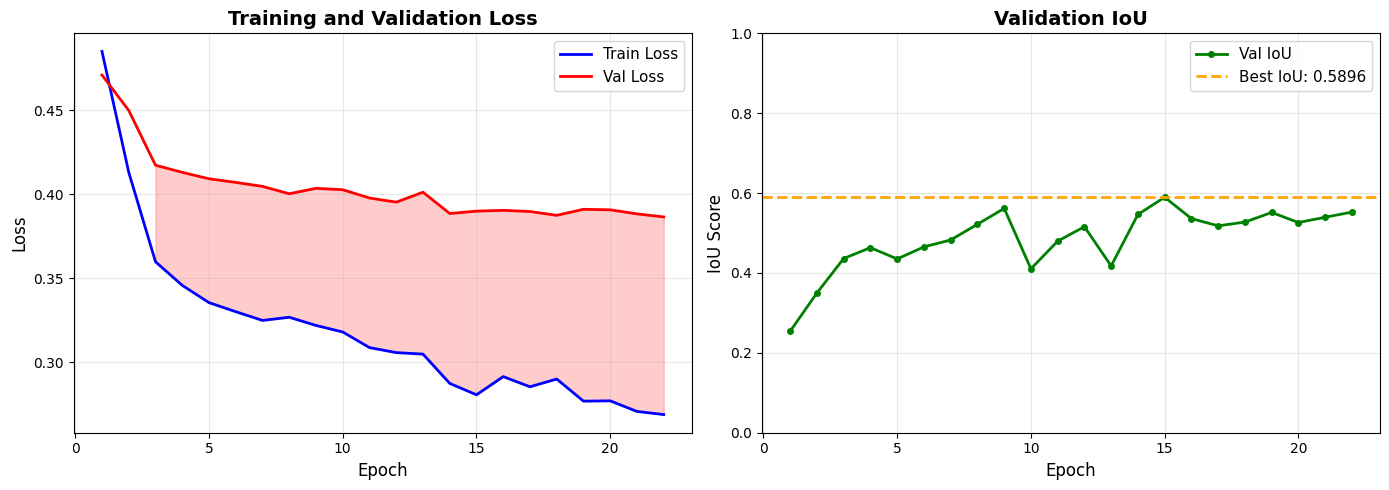


TRAINING ANALYSIS
Best IoU: 0.5896
Final Train Loss: 0.2687
Final Val Loss: 0.3864
Final Loss Gap (Train - Val): -0.1177

⚠️  OVERFITTING DETECTED:
   - Train loss is significantly lower than validation loss
   - Model is memorizing training data rather than generalizing
   - Consider: more regularization, dropout, or data augmentation


In [28]:
# ---------------------------
# 9) Visualize Training Curves - (Run after training)
# ---------------------------
# Check if training history exists (from training cell)
try:
    # Check if variables exist in global scope
    if 'train_losses' in globals() and len(train_losses) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        epochs = range(1, len(train_losses) + 1)

        # Plot 1: Loss curves
        axes[0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)

        # Highlight overfitting region (where gap is large)
        if len(train_losses) > 5:
            gap = np.array(train_losses) - np.array(val_losses)
            overfit_mask = gap < -0.05  # Where train loss is much lower than val loss
            if np.any(overfit_mask):
                axes[0].fill_between(epochs, train_losses, val_losses,
                                     where=overfit_mask, alpha=0.2, color='red',
                                     label='Overfitting region')

        # Plot 2: IoU curve
        axes[1].plot(epochs, val_ious, 'g-', label='Val IoU', linewidth=2, marker='o', markersize=4)
        axes[1].axhline(y=best_iou, color='orange', linestyle='--',
                        label=f'Best IoU: {best_iou:.4f}', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('IoU Score', fontsize=12)
        axes[1].set_title('Validation IoU', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])

        plt.tight_layout()
        plt.show()

        # Print analysis
        final_gap = train_losses[-1] - val_losses[-1]
        print("\n" + "="*60)
        print("TRAINING ANALYSIS")
        print("="*60)
        print(f"Best IoU: {best_iou:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")
        print(f"Final Val Loss: {val_losses[-1]:.4f}")
        print(f"Final Loss Gap (Train - Val): {final_gap:.4f}")

        if final_gap < -0.05:
            print("\n⚠️  OVERFITTING DETECTED:")
            print("   - Train loss is significantly lower than validation loss")
            print("   - Model is memorizing training data rather than generalizing")
            print("   - Consider: more regularization, dropout, or data augmentation")
        elif final_gap > 0.05:
            print("\n✓ Good generalization:")
            print("   - Validation loss is lower than training loss")
            print("   - Model is generalizing well")
        else:
            print("\n✓ Balanced training:")
            print("   - Train and validation losses are close")
            print("   - Model appears to be learning well")
    else:
        print("⚠️ Training history is empty. Run the training cell first.")
except NameError:
    print("⚠️ Training history not available. Please run the training cell (Cell 10) first.")


In [33]:
# ---------------------------
# 10) Final Test: Calc Metrics AND Save Images
# ---------------------------
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

print("\n================ TEST EVALUATION & SAVING ================\n")

# 1. Setup Output Directory
pred_out_dir = os.path.join(OUT_DIR, "batch_preds")
os.makedirs(pred_out_dir, exist_ok=True)
print(f"Saving images to: {pred_out_dir}")

# 2. Load Data & Model
test_ds = DepthDentDataset(test_pairs, augment=False)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# 3. Metrics Trackers
test_iou = 0.0
test_dice = 0.0
test_prec = 0.0
test_rec = 0.0
n_batches = 0

# 4. Helper to locate original filename
# We need this because DataLoader shuffles or batches data, so we need to keep track.
# Since shuffle=False, we can just use a counter.
total_file_idx = 0

with torch.no_grad():
    for inp, mask in tqdm(test_loader, desc="Testing & Saving"):
        inp = inp.to(device)
        mask = mask.to(device)

        # --- A. Predict ---
        outputs = model(inp)

        # --- B. Calculate Metrics (Batch level) ---
        test_iou  += iou_score_batch(outputs, mask)
        test_dice += dice_score_batch(outputs, mask)
        test_prec += precision_batch(outputs, mask)
        test_rec  += recall_batch(outputs, mask)
        n_batches += 1

        # --- C. Save Images (Item level) ---
        # Convert to numpy for saving
        preds_prob = torch.sigmoid(outputs).cpu().numpy() # (B, 1, H, W)
        inputs_np = inp.cpu().numpy()                     # (B, 3, H, W)
        masks_np = mask.cpu().numpy()                     # (B, 1, H, W)

        batch_size = inputs_np.shape[0]

        for i in range(batch_size):
            # Get original filename from the list
            if total_file_idx >= len(test_pairs): break
            original_path = test_pairs[total_file_idx][0]
            base = os.path.basename(original_path).replace("_dented_depth.npy", "")

            # Prepare Images
            # 1. Depth (Channel 0) - Scale 0.1-1.0 back to 0-255 for vis
            depth_img = (inputs_np[i, 0] * 255).astype(np.uint8)

            # 2. GT Mask
            gt_img = (masks_np[i, 0] * 255).astype(np.uint8)

            # 3. Pred Mask (Threshold 0.5)
            pred_img = (preds_prob[i, 0] > 0.5).astype(np.uint8) * 255

            # Save files
            cv2.imwrite(os.path.join(pred_out_dir, base + "_pred.png"), pred_img)

            # Optional: Save Side-by-Side Comparison (Depth | GT | Pred)
            if gt_img.shape != depth_img.shape:
                gt_img = cv2.resize(gt_img, (depth_img.shape[1], depth_img.shape[0]), interpolation=cv2.INTER_NEAREST)

            side_by_side = np.hstack([depth_img, gt_img, pred_img])
            cv2.imwrite(os.path.join(pred_out_dir, base + "_compare.png"), side_by_side)

            total_file_idx += 1

# 5. Print Final Averaged Metrics
avg_test_iou  = test_iou / n_batches
avg_test_dice = test_dice / n_batches
avg_test_prec = test_prec / n_batches
avg_test_rec  = test_rec / n_batches

print("\n========== FINAL TEST RESULTS ==========")
print(f"Test IoU      : {avg_test_iou:.4f}")
print(f"Test Dice     : {avg_test_dice:.4f}")
print(f"Test Precision: {avg_test_prec:.4f}")
print(f"Test Recall   : {avg_test_rec:.4f}")
print(f"✅ Images saved to: {pred_out_dir}")
print("========================================\n")


================ TEST EVALUATION & SAVING ================

Saving images to: /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/batch_preds


Testing & Saving: 100%|██████████| 45/45 [00:12<00:00,  3.64it/s]


========== FINAL TEST RESULTS ==========
Test IoU      : 0.6036
Test Dice     : 0.6588
Test Precision: 0.7170
Test Recall   : 0.8588
✅ Images saved to: /content/drive/MyDrive/Ai Y4 Sem 1/FYP/output_scene_dataset_4/predictions/batch_preds



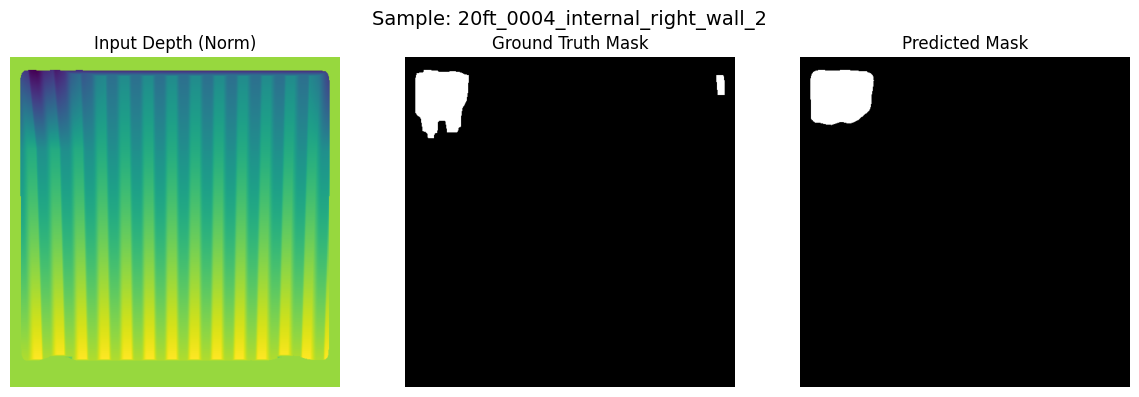

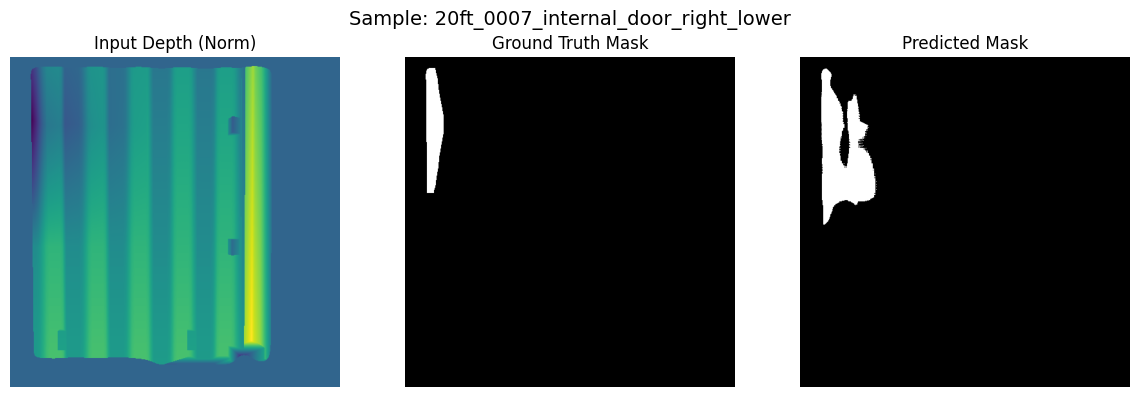

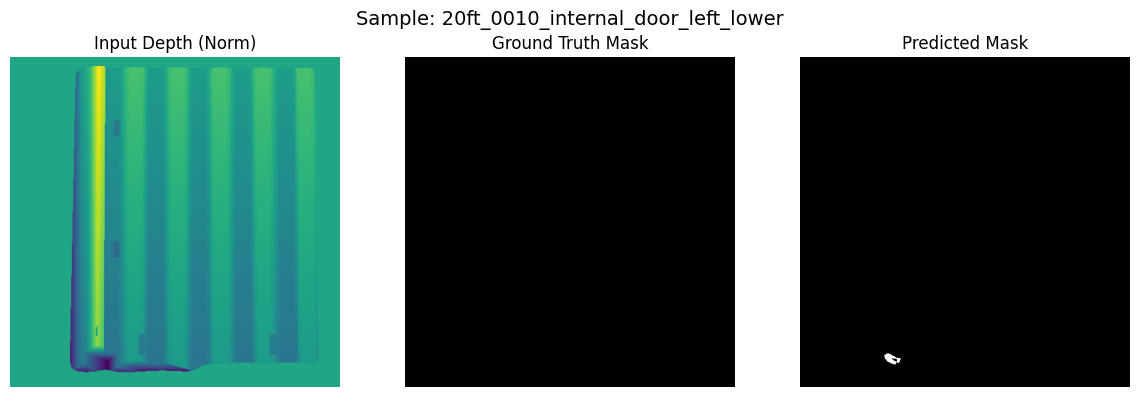

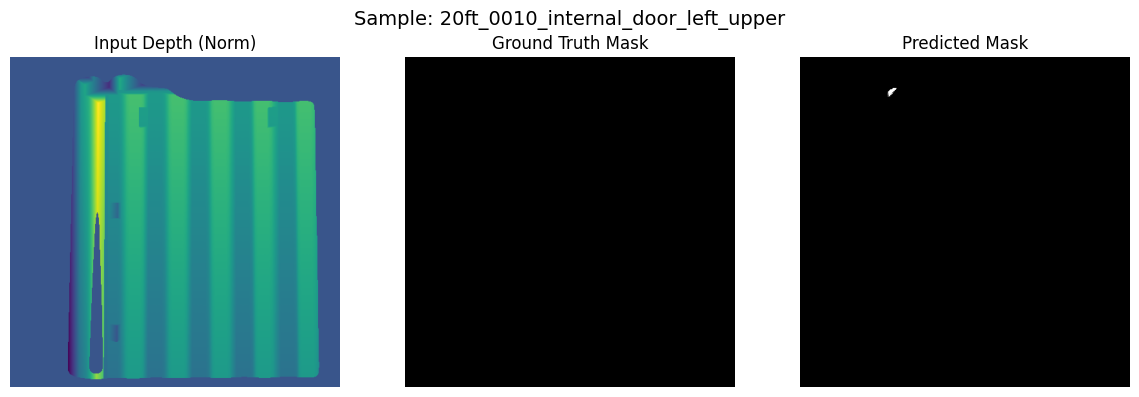

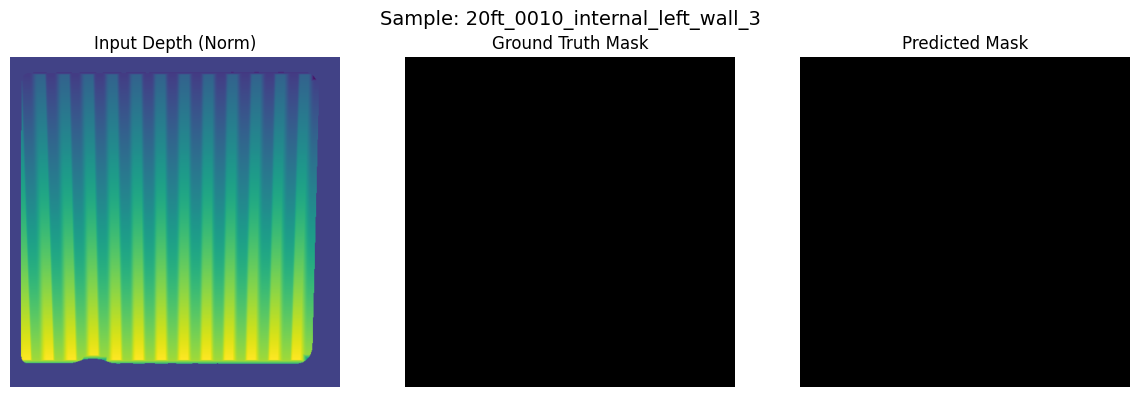

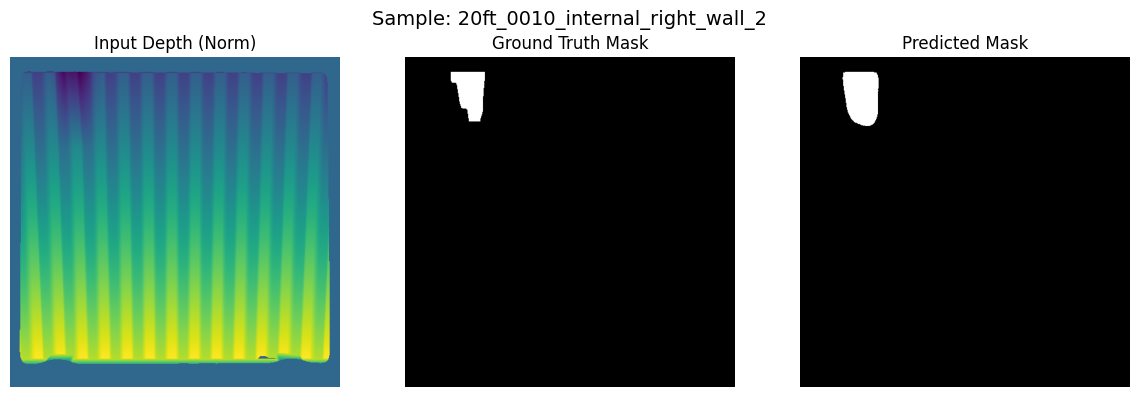

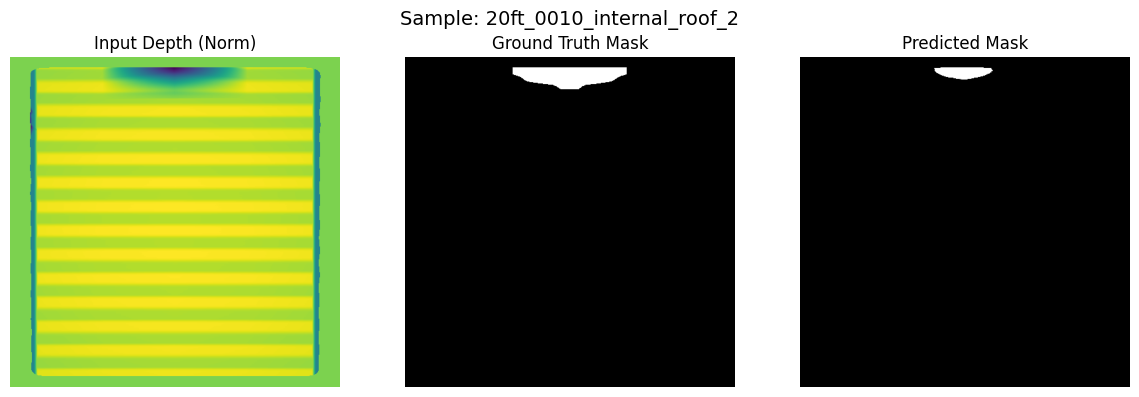

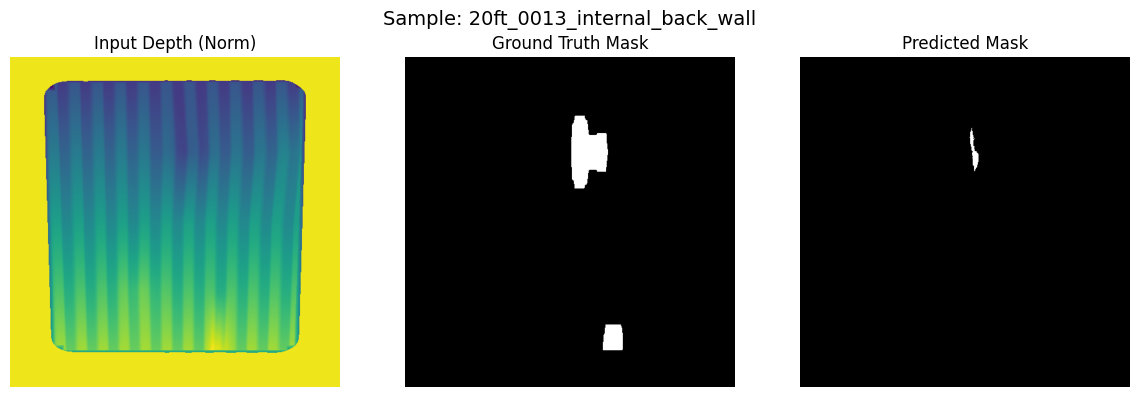

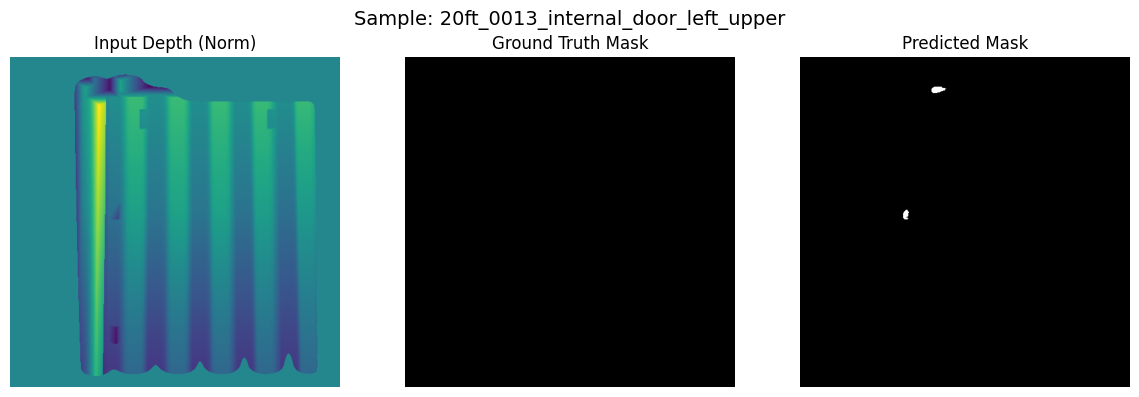

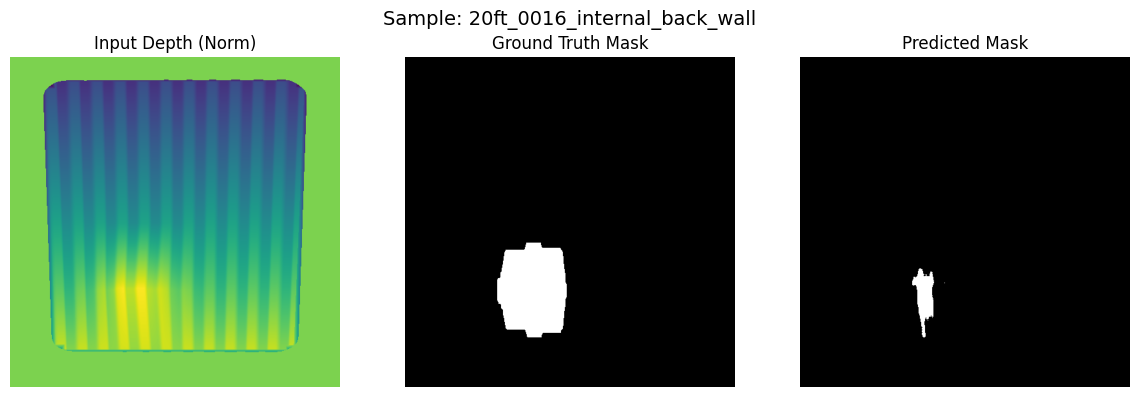

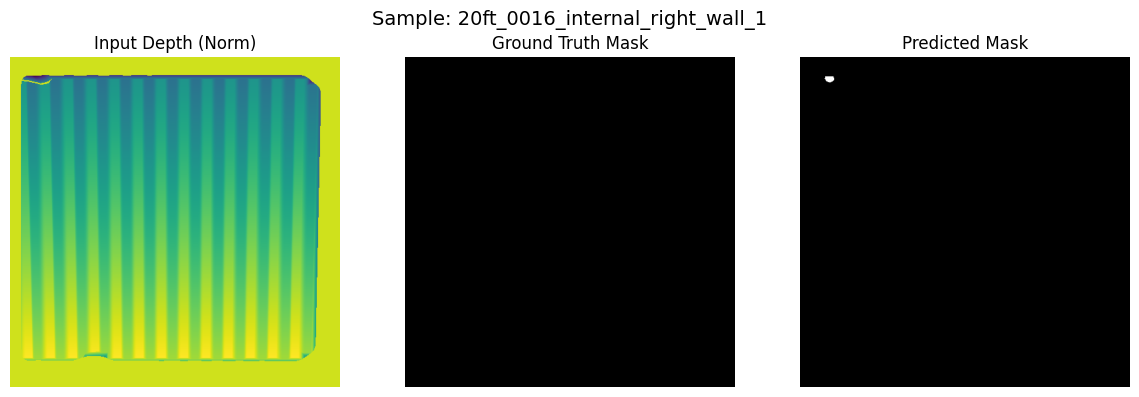

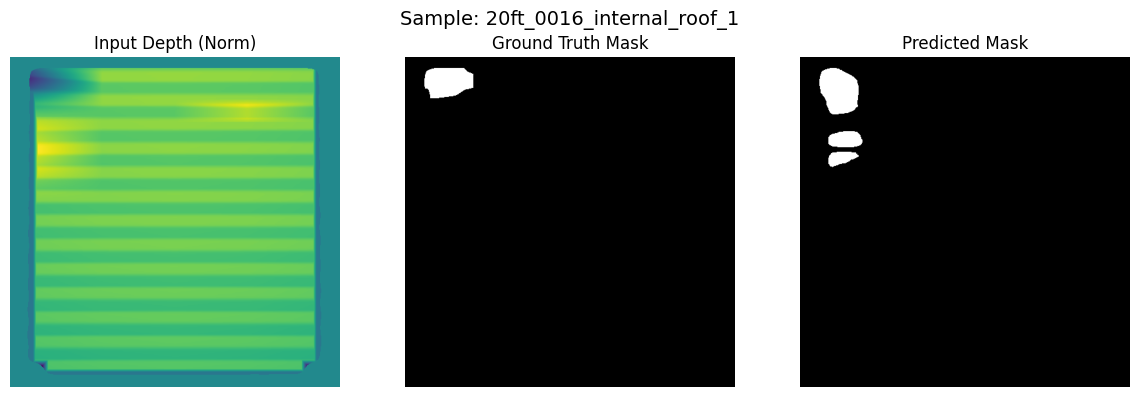

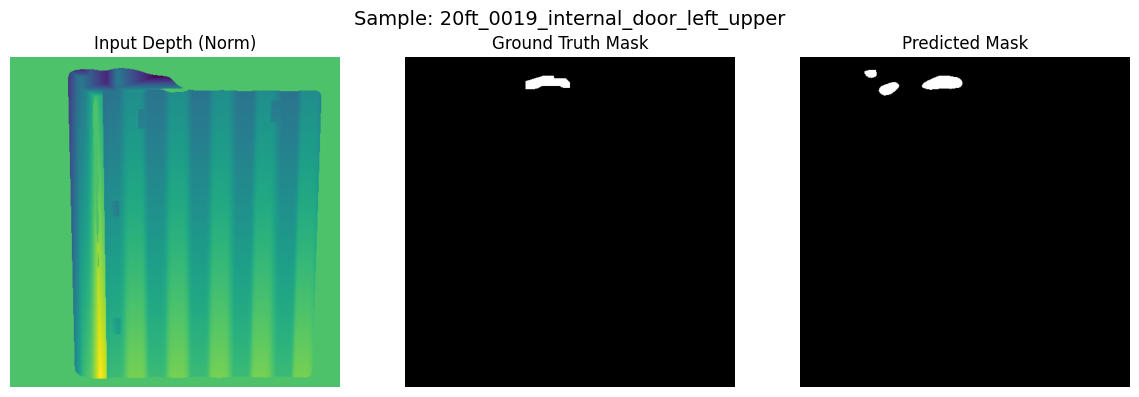

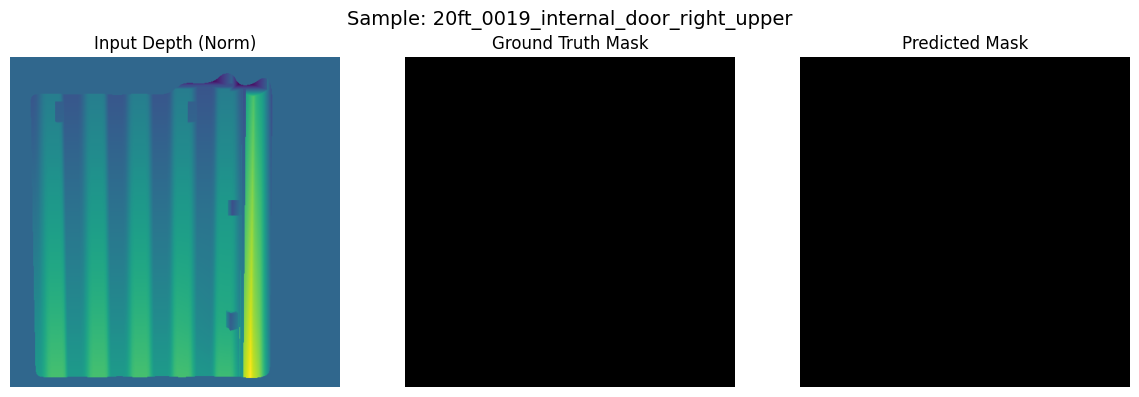

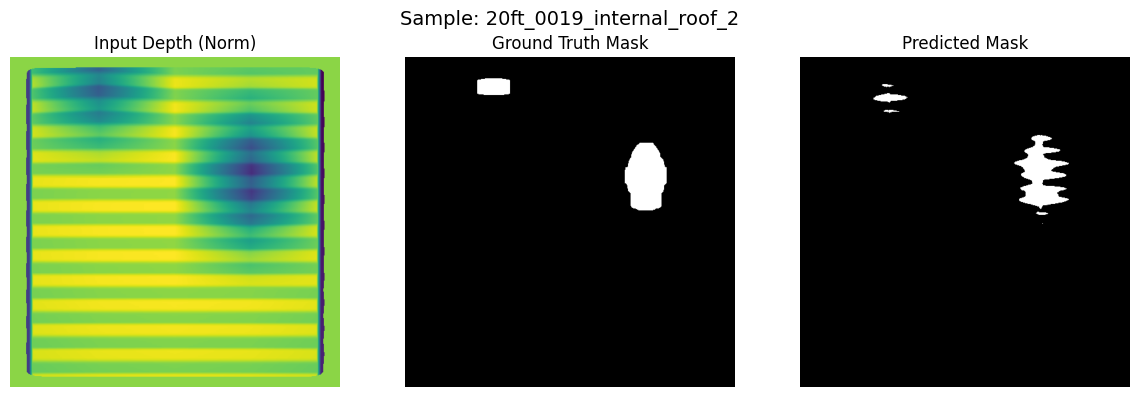

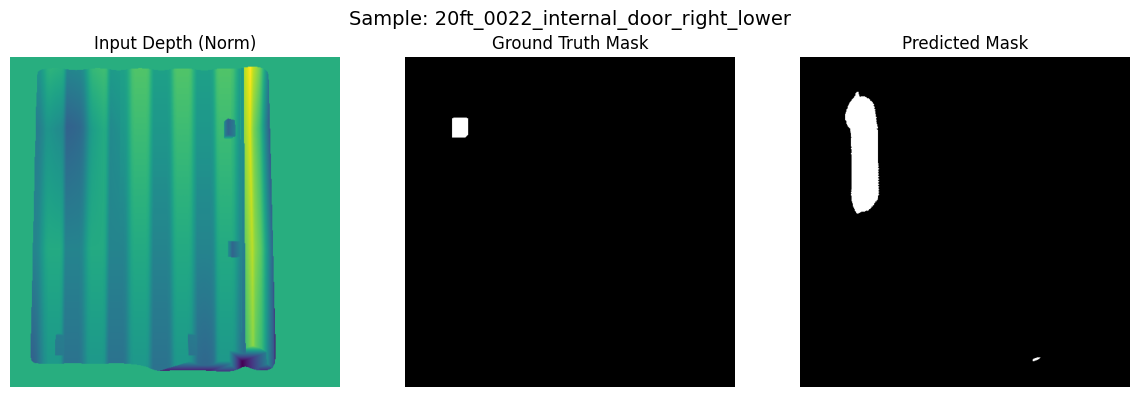

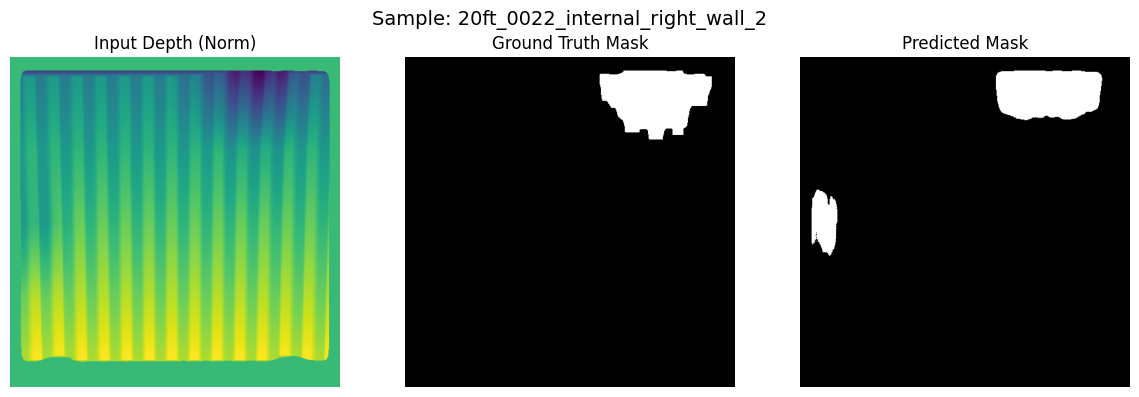

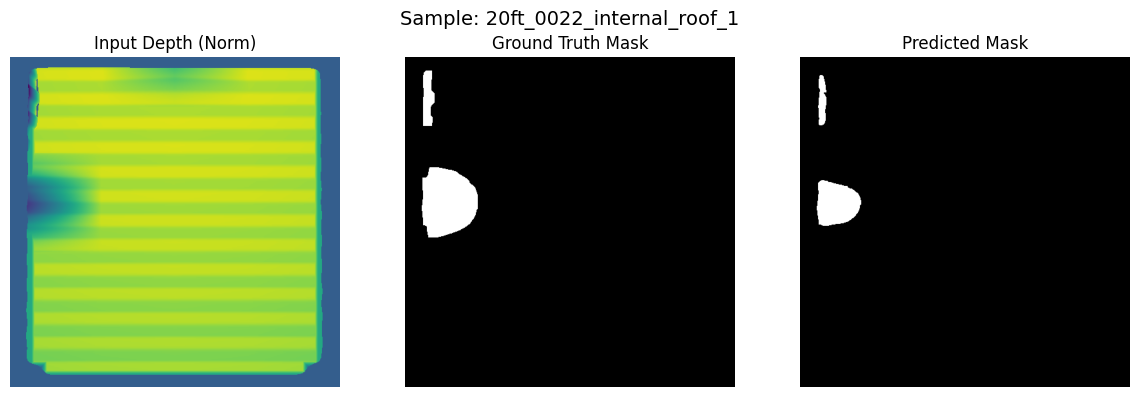

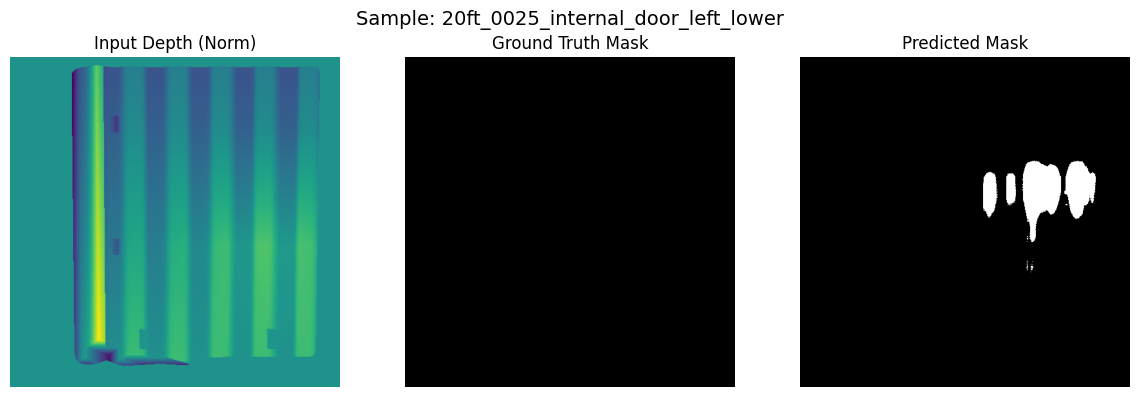

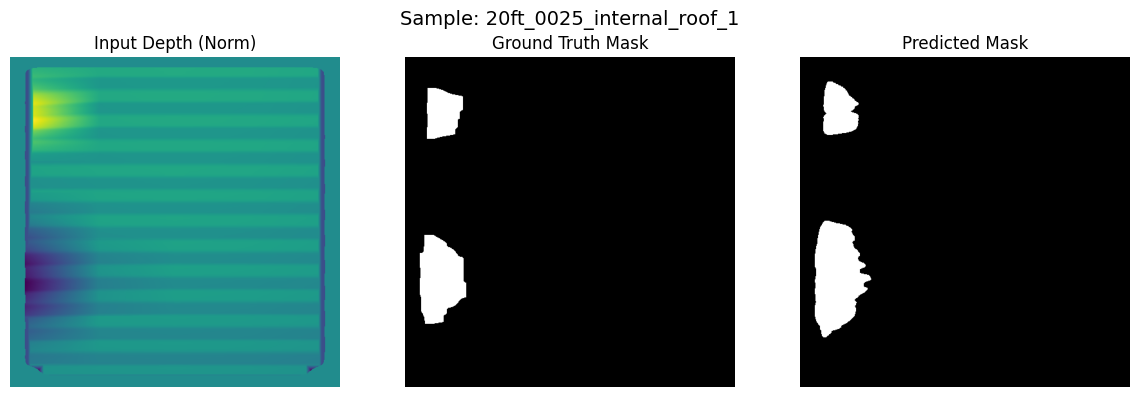

In [34]:
# ---------------------------
# 11) Visualization of Results
# ---------------------------
import matplotlib.pyplot as plt

# Get the list of prediction images we just saved
pred_files = sorted(glob.glob(os.path.join(pred_out_dir, "*_pred.png")))

# Pick random 3 or take first 3
num_to_show = min(20, len(pred_files))
vis_samples = pred_files[:num_to_show]

if len(vis_samples) == 0:
    print("No predictions found to visualize.")
else:
    for i, pred_path in enumerate(vis_samples):
        # Derive paths based on naming convention in Step 9
        base = os.path.basename(pred_path).replace("_pred.png", "")

        # Load Depth (Visual)
        depth_vis_path = os.path.join(pred_out_dir, base + "_gt_depth.png")
        if os.path.exists(depth_vis_path):
            depth_img = cv2.imread(depth_vis_path, cv2.IMREAD_GRAYSCALE)
        else:
            depth_img = np.zeros((256,256), dtype=np.uint8) # Fallback

        # Load GT Mask
        gt_mask_path = os.path.join(pred_out_dir, base + "_gt_mask.png")
        if os.path.exists(gt_mask_path):
            gt_mask_img = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            gt_mask_img = np.zeros_like(depth_img)

        # Load Prediction
        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample: {base}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Input Depth (Norm)")
        plt.imshow(depth_img, cmap="viridis")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask_img, cmap="gray")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_img, cmap="gray")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [25]:
import numpy as np

# Load one of your processed files
data = np.load(os.path.join(data_dir,'20ft_0001_internal_door_left_upper_dented_depth.npy'))

print(f"Min value: {np.min(data)}")
print(f"Max value: {np.max(data)}")

# Check if 0.0 exists in the data and how much of it
zeros = np.sum(data == 0.0)
total_pixels = data.size
print(f"Percentage of 0.0 pixels: {zeros / total_pixels * 100:.2f}%")

# CRITICAL CHECK:
# If your Valid Data has values like 0.001 or 0.0 (after normalization),
# then it is mathematically identical to your background.
unique_values = np.unique(data)
print(f"First 5 unique values: {unique_values[:5]}")

Min value: 0.0
Max value: 1.209882378578186
Percentage of 0.0 pixels: 36.60%
First 5 unique values: [0.        1.0474155 1.0474238 1.047428  1.0474364]
